In [19]:
import numpy as np # linear algebra
import os
import tensorflow as tf 
from tqdm import tqdm_notebook
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [20]:
id2code = {0:(0,0,0),1:(255,255,255)}
id2name = {0:'void',1:'vessel'}

In [21]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [22]:
def GrayScale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

In [23]:
# define datagenerator
data_gen_args = dict(rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=GrayScale)


mask_gen_args = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

test_gen_args = dict(rescale=1./255)
test_mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)

validation_frames_datagen = ImageDataGenerator(**data_gen_args)
validation_masks_datagen = ImageDataGenerator(**mask_gen_args)

test_frames_datagen = ImageDataGenerator(**test_gen_args)
test_masks_datagen = ImageDataGenerator(**test_mask_gen_args)

In [46]:
def TrainAugmentGenerator(seed=42, batch_size =5):
    os.chdir('/content/drive/MyDrive/pathe')
    train_image_generator = train_frames_datagen.flow_from_directory(
        "/content/drive/MyDrive/train/train_frames/", batch_size = batch_size, seed = seed, target_size=(256,256))
    
    train_mask_generator = train_masks_datagen.flow_from_directory(
        "/content/drive/MyDrive/train/train_labels/", batch_size = batch_size, seed = seed, target_size=(256,256))
    
    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [45]:
def TestAugmentGenerator(seed=42, batch_size =5):
    os.chdir('/content/drive/MyDrive/pathe')
    test_image_generator = test_frames_datagen.flow_from_directory(
        "/content/drive/MyDrive/test/test_frames", batch_size = batch_size, seed = seed, target_size=(256,256))
    
    test_mask_generator = test_masks_datagen.flow_from_directory(
        "/content/drive/MyDrive/test/test_labels/labels", batch_size = batch_size, seed = seed, target_size=(256,256))
    
    while True:
        X1i = test_image_generator.next()
        X2i = test_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [44]:
def ValidationAugmentGenerator(seed=42, batch_size =5):
    os.chdir('/content/drive/MyDrive/pathe')
    validation_image_generator = train_frames_datagen.flow_from_directory(
        "/content/drive/MyDrive/validate/val_frames/", batch_size = batch_size, seed = seed, target_size=(256,256))
    
    validation_mask_generator = train_masks_datagen.flow_from_directory(
        "/content/drive/MyDrive/validate/val_labels/", batch_size = batch_size, seed = seed, target_size=(256,256))
    
 
    while True:
        X1i =  validation_image_generator.next()
        X2i =   validation_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [38]:
def double_conv(inputs,in_c,out_c,bn=True,dilation_rate=1):
    conv = Conv2D(in_c,out_c, activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    conv = Dropout(0.1)(conv)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Conv2D(in_c,out_c, activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv)
    conv = Dropout(0.25)(conv)
    if bn:
        conv = BatchNormalization()(conv)
    
    return conv

In [39]:
def Unet(n_filters = 16, bn = True, dilation_rate = 1):
 
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape)
    print(inputs)
    
    conv1 = double_conv(inputs,n_filters*1,(3,3),bn=True,dilation_rate=1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = double_conv(pool1,n_filters*2,(3,3),bn=True,dilation_rate=1)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = double_conv(pool2,n_filters*4,(3,3),bn=True,dilation_rate=1)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = double_conv(pool3,n_filters*8,(3,3),bn=True,dilation_rate=1)
       
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = double_conv(pool4,n_filters*16,(3,3),bn=True,dilation_rate=1)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = double_conv(up6,n_filters*8,(3,3),bn=True,dilation_rate=1)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = double_conv(up7,n_filters*4,(3,3),bn=True,dilation_rate=1)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = double_conv(up8,n_filters*2,(3,3),bn=True,dilation_rate=1)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = double_conv(up9,n_filters*1,(3,3),bn=True,dilation_rate=1)
        
    conv10 = Conv2D(2, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

model = Unet(n_filters=32)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [40]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [41]:
import datetime
mc = ModelCheckpoint(mode='min', filepath='eye_vessel_segment.h5', monitor='val_loss', save_best_only='True', save_weights_only='True', 
                     verbose=1)
log_dir = "/kaggle/working/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(mode='min', monitor='val_loss', patience=10, verbose=1)
tb = TensorBoard(log_dir=log_dir, write_graph=True, histogram_freq=1)
callbacks = [mc, es,tb]

In [42]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy',tversky_loss,dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 32) 128         dropout_18[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
num_epochs = 30
batch_size = 10
result = model.fit_generator(TrainAugmentGenerator(batch_size=batch_size), steps_per_epoch=234//batch_size,
                validation_data = ValidationAugmentGenerator(batch_size=batch_size),
                validation_steps=26//batch_size, epochs=num_epochs, callbacks=callbacks)
# model.save_weights("eye_vessel_segment.h5", overwrite=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 234 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.7163 - tversky_loss: 0.4262 - dice_coef: 0.5590 Found 26 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
23/23 [==============================] - 525s 23s/step - loss: 0.5747 - accuracy: 0.7163 - tversky_loss: 0.4262 - dice_coef: 0.5590 - val_loss: 159.1060 - val_accuracy: 0.0266 - val_tversky_loss: 0.9709 - val_dice_coef: 0.0284

Epoch 00001: val_loss improved from inf to 159.10605, saving model to eye_vessel_segment.h5
Epoch 2/30
23/23 [==============================] - 488s 22s/step - loss: 0.3789 - accuracy: 0.8557 - tversky_loss: 0.3412 - dice_coef: 0.6418 - val_loss: 35.4340 - val_accuracy: 0.1136 - val_tversky_loss: 0.9051 - val_dice_coef: 0.0924

Epoch 00002: val_loss improved from 159.10605 to 35.43396, saving model to eye_vessel_segment.h5
Epoch 3/30
23/23 [============================

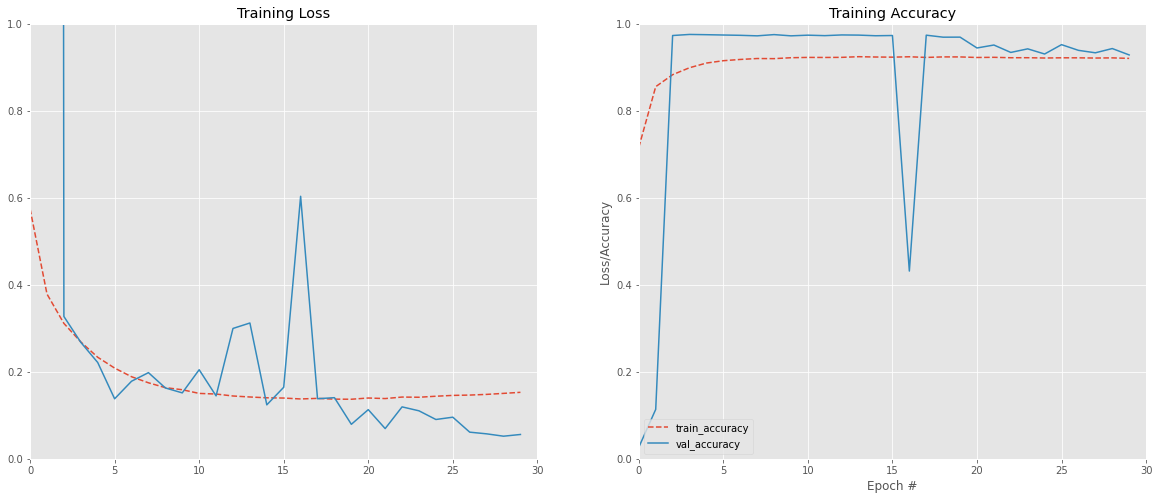

In [48]:
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
scale_factor = 5
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss",linestyle='dashed')
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)
plt.xlim(0,N)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy",linestyle='dashed')
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)
plt.xlim(0,N)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [67]:
testing_gen = TestAugmentGenerator(batch_size=10)
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
pred_all= (pred_all > 0.5).astype(np.uint8)
np.shape(pred_all)

Found 20 images belonging to 1 classes.
Found 0 images belonging to 0 classes.


(10, 256, 256, 2)

In [50]:
from skimage.transform import resize
from skimage.morphology import label

In [51]:
preds_test_upsampled = []
for i in range(len(pred_all)):
    preds_test_upsampled.append(resize(np.squeeze(pred_all[i]), 
                                       (256, 256), 
                                       mode='constant', preserve_range=True))

In [52]:
x = onehot_to_rgb(preds_test_upsampled[1],id2code)

In [54]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

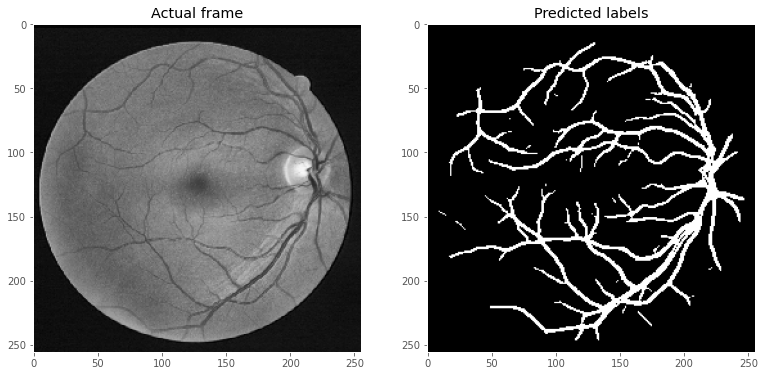

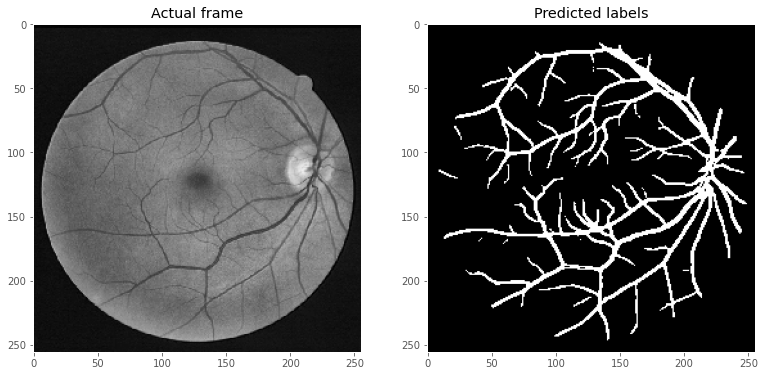

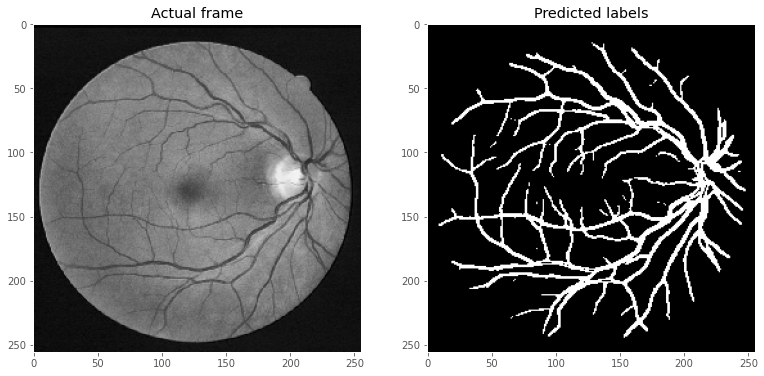

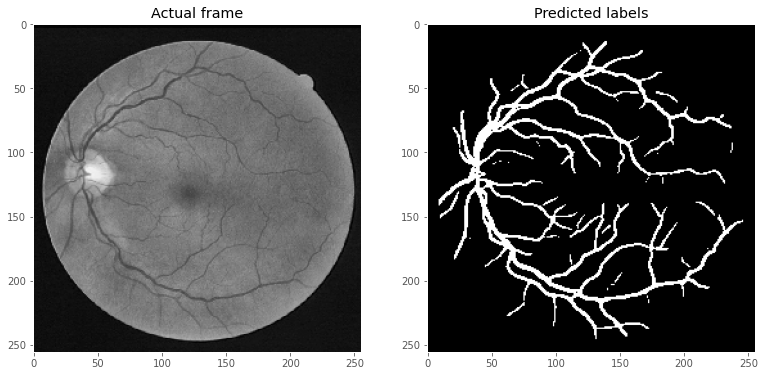

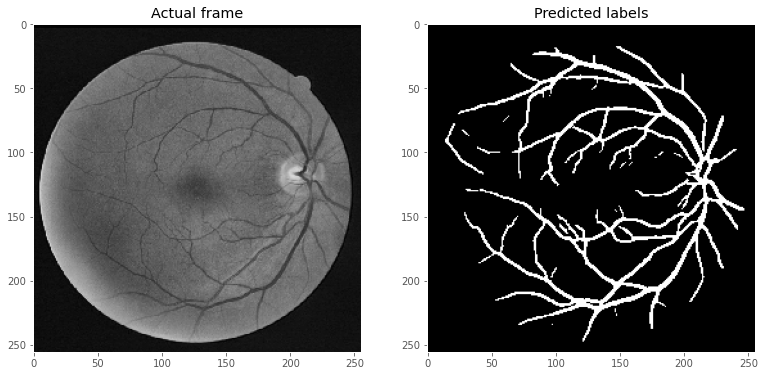

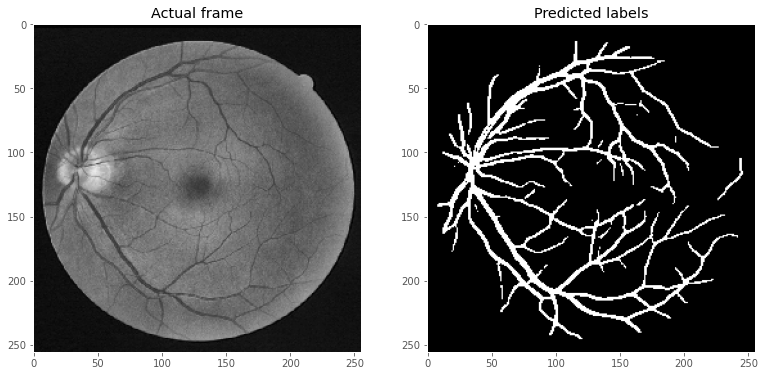

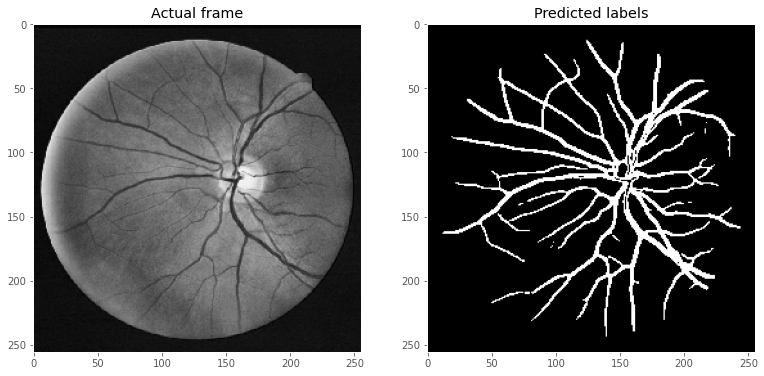

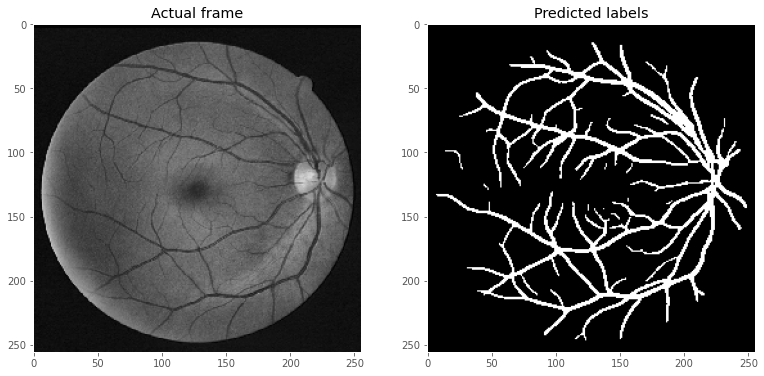

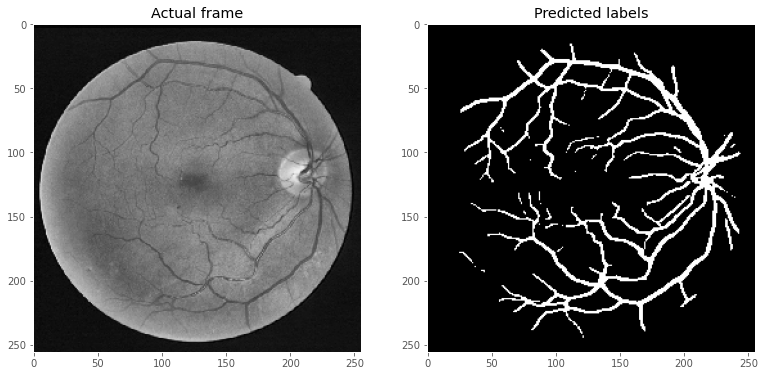

In [72]:
for i in range(1,np.shape(preds_test_upsampled)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax3 = fig.add_subplot(1,3,2)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(preds_test_upsampled[i],id2code))
    ax3.grid(b=None)
    
    plt.show()